In [1]:
import copy
from pathlib import Path
import random
from statistics import mean

import numpy as np
import torch
from torch import nn
from tqdm import tqdm

In [2]:
random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
n_way = 5
n_shot = 5
n_query = 10

DEVICE = "cuda"
n_workers = 12

In [4]:
import os
import json

class_names = [
    'two_up_inverted',
    'dislike',
    'two_up',
    'mute',
    'three2',
    'rock',
    'four',
    'stop',
    'ok',
    'three',
    'stop_inverted',
    'peace',
    'palm',
    'fist',
    'like',
    'one',
    'peace_inverted',
    'call'
]

root_path = '/home/soumik/Code/cropped/test'

class_roots = [os.path.join(root_path, class_name) for class_name in class_names]

data = {
    "class_names": class_names,
    "class_roots": class_roots
}

# Save data to JSON file
json_file = '/home/soumik/Code/cropped/test/classes.json'
with open(json_file, 'w') as f:
    json.dump(data, f, indent=4)

print(f"Generated JSON file: {json_file}")


Generated JSON file: /home/soumik/Code/cropped/test/classes.json


In [5]:
from easyfsl.datasets.easy_set import EasySet
from torchvision import transforms

train_set=EasySet('/home/soumik/Code/cropped/train/classes.json',transform=transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()]))
val_set=EasySet('/home/soumik/Code/cropped/val/classes.json',transform=transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()]))
test_set=EasySet('/home/soumik/Code/cropped/test/classes.json',transform=transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()]))

In [6]:
from easyfsl.samplers import TaskSampler
from torch.utils.data import DataLoader

n_tasks_per_epoch = 500
n_validation_tasks = 100

train_sampler = TaskSampler(
    train_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_tasks_per_epoch
)
val_sampler = TaskSampler(
    val_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
)
test_sampler = TaskSampler(
    test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
)

# Finally, the DataLoader. We customize the collate_fn so that batches are delivered
# in the shape: (support_images, support_labels, query_images, query_labels, class_ids)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)
val_loader = DataLoader(
    val_set,
    batch_sampler=val_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

n_test_tasks = 1000

test_sampler = TaskSampler(
    test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_test_tasks
)
test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [7]:
from easyfsl.methods import PrototypicalNetworks
from easyfsl.modules import resnet12

convolutional_network = resnet12()
few_shot_classifier = PrototypicalNetworks(convolutional_network).to(DEVICE)

In [8]:
from torch.optim import SGD, Optimizer
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter


LOSS_FUNCTION = nn.CrossEntropyLoss()

n_epochs = 100
scheduler_milestones = [120, 160]
scheduler_gamma = 0.1
learning_rate = 1e-2
tb_logs_dir = Path("../logs/proto")

train_optimizer = SGD(
    few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
)
train_scheduler = MultiStepLR(
    train_optimizer,
    milestones=scheduler_milestones,
    gamma=scheduler_gamma,
)

tb_writer = SummaryWriter(log_dir=str(tb_logs_dir))

In [9]:
from easyfsl.methods import FewShotClassifier

def training_epoch(
    model: FewShotClassifier, data_loader: DataLoader, optimizer: Optimizer
):
    all_loss = []
    model.train()
    with tqdm(
        enumerate(data_loader), total=len(data_loader), desc="Training"
    ) as tqdm_train:
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            _,
        ) in tqdm_train:
            optimizer.zero_grad()
            model.process_support_set(
                support_images.to(DEVICE), support_labels.to(DEVICE)
            )
            classification_scores = model(query_images.to(DEVICE))

            loss = LOSS_FUNCTION(classification_scores, query_labels.to(DEVICE))
            loss.backward()
            optimizer.step()

            all_loss.append(loss.item())

            tqdm_train.set_postfix(loss=mean(all_loss))

    return mean(all_loss)

In [10]:
from easyfsl.utils import evaluate

train_losses=[]
validation_accuracies=[]
best_state = few_shot_classifier.state_dict()
best_validation_accuracy = 0.0
model_save_path="/home/soumik/Code/easy-few-shot-learning/savedmodels/proto.pth"
for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch(few_shot_classifier, train_loader, train_optimizer)
    train_losses.append(average_loss)
    
    validation_accuracy = evaluate(
        few_shot_classifier, val_loader, device=DEVICE, tqdm_prefix="Validation"
    )
    validation_accuracies.append(validation_accuracy)

    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_state = copy.deepcopy(few_shot_classifier.state_dict())
        # state_dict() returns a reference to the still evolving model's state so we deepcopy
        # https://pytorch.org/tutorials/beginner/saving_loading_models
        torch.save(best_state, model_save_path)
        print("Ding ding ding! We found a new best model!")

    tb_writer.add_scalar("Train/loss", average_loss, epoch)
    tb_writer.add_scalar("Val/acc", validation_accuracy, epoch)

    # Warn the scheduler that we did an epoch
    # so it knows when to decrease the learning rate
    train_scheduler.step()

Epoch 0


Validation: 100%|██████████| 100/100 [00:02<00:00, 33.71it/s, accuracy=0.915]


Ding ding ding! We found a new best model!
Epoch 1


Validation: 100%|██████████| 100/100 [00:03<00:00, 32.58it/s, accuracy=0.961]


Ding ding ding! We found a new best model!
Epoch 2


Validation: 100%|██████████| 100/100 [00:03<00:00, 30.85it/s, accuracy=0.977]


Ding ding ding! We found a new best model!
Epoch 3


Validation: 100%|██████████| 100/100 [00:03<00:00, 29.40it/s, accuracy=0.982]


Ding ding ding! We found a new best model!
Epoch 4


Validation: 100%|██████████| 100/100 [00:03<00:00, 29.94it/s, accuracy=0.989]


Ding ding ding! We found a new best model!
Epoch 5


Validation: 100%|██████████| 100/100 [00:03<00:00, 29.90it/s, accuracy=0.988]

Epoch 6



Validation: 100%|██████████| 100/100 [00:03<00:00, 30.47it/s, accuracy=0.996]


Ding ding ding! We found a new best model!
Epoch 7


Validation: 100%|██████████| 100/100 [00:03<00:00, 31.27it/s, accuracy=0.993]

Epoch 8



Validation: 100%|██████████| 100/100 [00:03<00:00, 30.82it/s, accuracy=0.996]

Epoch 9



Validation: 100%|██████████| 100/100 [00:03<00:00, 29.74it/s, accuracy=0.995]

Epoch 10



Validation: 100%|██████████| 100/100 [00:03<00:00, 31.62it/s, accuracy=0.996]

Epoch 11



Validation: 100%|██████████| 100/100 [00:03<00:00, 30.60it/s, accuracy=0.994]

Epoch 12



Validation: 100%|██████████| 100/100 [00:03<00:00, 30.30it/s, accuracy=0.997]


Ding ding ding! We found a new best model!
Epoch 13


Validation: 100%|██████████| 100/100 [00:03<00:00, 31.68it/s, accuracy=0.999]


Ding ding ding! We found a new best model!
Epoch 14


Validation: 100%|██████████| 100/100 [00:03<00:00, 30.60it/s, accuracy=0.998]


Epoch 15


Validation: 100%|██████████| 100/100 [00:03<00:00, 31.55it/s, accuracy=0.999]


Ding ding ding! We found a new best model!
Epoch 16


Validation: 100%|██████████| 100/100 [00:03<00:00, 30.83it/s, accuracy=0.998]

Epoch 17



Validation: 100%|██████████| 100/100 [00:02<00:00, 34.19it/s, accuracy=0.998]

Epoch 18



Validation: 100%|██████████| 100/100 [00:03<00:00, 32.57it/s, accuracy=1]   


Ding ding ding! We found a new best model!
Epoch 19


Validation: 100%|██████████| 100/100 [00:03<00:00, 32.81it/s, accuracy=1]   

Epoch 20



Validation: 100%|██████████| 100/100 [00:02<00:00, 37.16it/s, accuracy=0.999]

Epoch 21



Validation: 100%|██████████| 100/100 [00:03<00:00, 32.51it/s, accuracy=0.999]

Epoch 22



Validation: 100%|██████████| 100/100 [00:03<00:00, 32.40it/s, accuracy=1]


Ding ding ding! We found a new best model!
Epoch 23


Validation: 100%|██████████| 100/100 [00:03<00:00, 30.91it/s, accuracy=1]   

Epoch 24



Validation: 100%|██████████| 100/100 [00:03<00:00, 30.79it/s, accuracy=1]   


Epoch 25


Validation: 100%|██████████| 100/100 [00:03<00:00, 32.64it/s, accuracy=1]

Epoch 26



Validation: 100%|██████████| 100/100 [00:03<00:00, 32.98it/s, accuracy=1]

Epoch 27



Validation: 100%|██████████| 100/100 [00:02<00:00, 33.36it/s, accuracy=1]

Epoch 28



Validation: 100%|██████████| 100/100 [00:03<00:00, 32.73it/s, accuracy=1]

Epoch 29



Validation: 100%|██████████| 100/100 [00:03<00:00, 32.12it/s, accuracy=1]

Epoch 30



Validation: 100%|██████████| 100/100 [00:03<00:00, 33.13it/s, accuracy=1]


Epoch 31


Validation: 100%|██████████| 100/100 [00:03<00:00, 32.94it/s, accuracy=0.998]

Epoch 32



Validation: 100%|██████████| 100/100 [00:02<00:00, 33.80it/s, accuracy=1]

Epoch 33



Validation: 100%|██████████| 100/100 [00:03<00:00, 32.79it/s, accuracy=1]

Epoch 34



Validation: 100%|██████████| 100/100 [00:03<00:00, 33.01it/s, accuracy=1]

Epoch 35



Validation: 100%|██████████| 100/100 [00:02<00:00, 33.71it/s, accuracy=1]

Epoch 36



Validation: 100%|██████████| 100/100 [00:03<00:00, 32.56it/s, accuracy=1]

Epoch 37



Validation: 100%|██████████| 100/100 [00:03<00:00, 30.85it/s, accuracy=1]

Epoch 38



Validation: 100%|██████████| 100/100 [00:03<00:00, 32.03it/s, accuracy=0.992]

Epoch 39



Validation: 100%|██████████| 100/100 [00:03<00:00, 30.34it/s, accuracy=0.995]

Epoch 40



Validation: 100%|██████████| 100/100 [00:03<00:00, 31.68it/s, accuracy=0.999]

Epoch 41



Validation: 100%|██████████| 100/100 [00:03<00:00, 33.33it/s, accuracy=0.995]

Epoch 42



Validation: 100%|██████████| 100/100 [00:02<00:00, 38.38it/s, accuracy=0.998]

Epoch 43



Validation: 100%|██████████| 100/100 [00:02<00:00, 33.49it/s, accuracy=0.999]

Epoch 44



Validation: 100%|██████████| 100/100 [00:02<00:00, 33.88it/s, accuracy=0.998]

Epoch 45



Validation: 100%|██████████| 100/100 [00:02<00:00, 33.48it/s, accuracy=0.998]

Epoch 46



Validation: 100%|██████████| 100/100 [00:02<00:00, 34.20it/s, accuracy=1]

Epoch 47



Validation: 100%|██████████| 100/100 [00:03<00:00, 32.07it/s, accuracy=1]   

Epoch 48



Validation: 100%|██████████| 100/100 [00:01<00:00, 70.36it/s, accuracy=0.999]

Epoch 49



Validation: 100%|██████████| 100/100 [00:01<00:00, 69.99it/s, accuracy=1]

Epoch 50



Validation: 100%|██████████| 100/100 [00:01<00:00, 70.81it/s, accuracy=1]

Epoch 51



Validation: 100%|██████████| 100/100 [00:01<00:00, 68.82it/s, accuracy=1]

Epoch 52



Validation: 100%|██████████| 100/100 [00:01<00:00, 62.94it/s, accuracy=1]


Epoch 53


Validation: 100%|██████████| 100/100 [00:01<00:00, 68.24it/s, accuracy=1]

Epoch 54



Validation: 100%|██████████| 100/100 [00:01<00:00, 62.01it/s, accuracy=1]

Epoch 55



Validation: 100%|██████████| 100/100 [00:01<00:00, 63.24it/s, accuracy=1]

Epoch 56



Validation: 100%|██████████| 100/100 [00:01<00:00, 68.86it/s, accuracy=1]

Epoch 57



Validation: 100%|██████████| 100/100 [00:01<00:00, 66.16it/s, accuracy=1]

Epoch 58



Validation: 100%|██████████| 100/100 [00:01<00:00, 70.70it/s, accuracy=1]


Epoch 59


Validation: 100%|██████████| 100/100 [00:01<00:00, 69.02it/s, accuracy=1]

Epoch 60



Validation: 100%|██████████| 100/100 [00:01<00:00, 62.55it/s, accuracy=1]

Epoch 61



Validation: 100%|██████████| 100/100 [00:01<00:00, 56.70it/s, accuracy=1]

Epoch 62



Validation: 100%|██████████| 100/100 [00:01<00:00, 57.59it/s, accuracy=1]

Epoch 63



Validation: 100%|██████████| 100/100 [00:01<00:00, 66.25it/s, accuracy=1]

Epoch 64



Validation: 100%|██████████| 100/100 [00:01<00:00, 64.88it/s, accuracy=1]

Epoch 65



Validation: 100%|██████████| 100/100 [00:01<00:00, 65.37it/s, accuracy=1]

Epoch 66



Validation: 100%|██████████| 100/100 [00:01<00:00, 62.14it/s, accuracy=1]

Epoch 67



Validation: 100%|██████████| 100/100 [00:01<00:00, 62.66it/s, accuracy=1]

Epoch 68



Validation: 100%|██████████| 100/100 [00:01<00:00, 59.28it/s, accuracy=1]

Epoch 69



Validation: 100%|██████████| 100/100 [00:01<00:00, 58.12it/s, accuracy=1]

Epoch 70



Validation: 100%|██████████| 100/100 [00:01<00:00, 66.65it/s, accuracy=1]

Epoch 71



Validation: 100%|██████████| 100/100 [00:01<00:00, 57.75it/s, accuracy=0.965]

Epoch 72



Validation: 100%|██████████| 100/100 [00:01<00:00, 60.13it/s, accuracy=0.993]

Epoch 73



Validation: 100%|██████████| 100/100 [00:01<00:00, 66.12it/s, accuracy=0.999]

Epoch 74



Validation: 100%|██████████| 100/100 [00:01<00:00, 59.29it/s, accuracy=0.996]

Epoch 75



Validation: 100%|██████████| 100/100 [00:01<00:00, 66.75it/s, accuracy=0.998]

Epoch 76



Validation: 100%|██████████| 100/100 [00:01<00:00, 57.48it/s, accuracy=0.993]

Epoch 77



Validation: 100%|██████████| 100/100 [00:01<00:00, 57.76it/s, accuracy=0.999]

Epoch 78



Validation: 100%|██████████| 100/100 [00:01<00:00, 54.31it/s, accuracy=0.999]

Epoch 79



Validation: 100%|██████████| 100/100 [00:01<00:00, 65.24it/s, accuracy=0.997]

Epoch 80



Validation: 100%|██████████| 100/100 [00:01<00:00, 64.64it/s, accuracy=0.999]

Epoch 81



Validation: 100%|██████████| 100/100 [00:01<00:00, 59.69it/s, accuracy=1]   

Epoch 82



Validation: 100%|██████████| 100/100 [00:01<00:00, 60.56it/s, accuracy=1]

Epoch 83



Validation: 100%|██████████| 100/100 [00:01<00:00, 67.33it/s, accuracy=1]

Epoch 84



Validation: 100%|██████████| 100/100 [00:01<00:00, 65.76it/s, accuracy=1]   

Epoch 85



Validation: 100%|██████████| 100/100 [00:01<00:00, 56.94it/s, accuracy=0.999]


Epoch 86


Validation: 100%|██████████| 100/100 [00:01<00:00, 58.97it/s, accuracy=1]   


Epoch 87


Validation: 100%|██████████| 100/100 [00:01<00:00, 60.42it/s, accuracy=1]

Epoch 88



Validation: 100%|██████████| 100/100 [00:01<00:00, 64.10it/s, accuracy=0.997]

Epoch 89



Validation: 100%|██████████| 100/100 [00:01<00:00, 60.62it/s, accuracy=0.998]

Epoch 90



Validation: 100%|██████████| 100/100 [00:01<00:00, 67.34it/s, accuracy=0.997]

Epoch 91



Validation: 100%|██████████| 100/100 [00:01<00:00, 60.18it/s, accuracy=0.997]

Epoch 92



Validation: 100%|██████████| 100/100 [00:01<00:00, 60.52it/s, accuracy=0.999]

Epoch 93



Validation: 100%|██████████| 100/100 [00:01<00:00, 59.64it/s, accuracy=1]

Epoch 94



Validation: 100%|██████████| 100/100 [00:01<00:00, 66.66it/s, accuracy=1]

Epoch 95



Validation: 100%|██████████| 100/100 [00:01<00:00, 59.51it/s, accuracy=0.999]

Epoch 96



Validation: 100%|██████████| 100/100 [00:01<00:00, 59.19it/s, accuracy=0.998]

Epoch 97



Validation: 100%|██████████| 100/100 [00:01<00:00, 66.95it/s, accuracy=0.999]

Epoch 98



Validation: 100%|██████████| 100/100 [00:01<00:00, 64.92it/s, accuracy=1]   

Epoch 99



Validation: 100%|██████████| 100/100 [00:01<00:00, 58.34it/s, accuracy=1]   


In [11]:
accuracy = evaluate(few_shot_classifier, test_loader, device=DEVICE)
print(f"Average accuracy : {(100 * accuracy):.2f} %")

100%|██████████| 1000/1000 [00:15<00:00, 64.19it/s, accuracy=0.993]

Average accuracy : 99.34 %


# Loading the best model

In [12]:
few_shot_classifier.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

# Perform predictions in your custom support and query set

In [13]:

import torchvision.transforms as tt
import torch
from torchvision.datasets import ImageFolder
from easyfsl.methods import FewShotClassifier
from torch.utils.data import DataLoader
import PIL

class FewShotPredictor :
    """

        This class aims to implement a predictor for a Few-shot classifier.

        The few shot classifiers need a support set that will be used for calculating the distance between the support set and the query image.

        To load the support we have used an ImageFolder Dataset, which needs to have the following structure:

        folder:
          |_ class_name_folder_1:
                 |_ image_1
                 |_  …
                 |_ image_n
          |_ class_name_folder_2:
                 |_ image_1
                 |_  …
                 |_ image_n

        The folder must contain the same number of images per class, being the total images (n_way * n_shot).

        There must be n_way folders with n_shot images per folder.

    """

    def __init__(self ,
                 classifier: FewShotClassifier,
                 device,
                 path_to_support_images,
                 n_way,
                 n_shot,
                 input_size=28):

        """
            :param classifier: created and loaded model
            :param device: device to be executed
            :param path_to_support_images: path to creating a support set
            :param n_way: number of classes
            :param n_shot: number of images on each class
            :param input_size: size of image

        """
        self.classifier = classifier
        self.device = device

        self.predict_transformation = tt.Compose([
            tt.Resize((input_size, input_size)),
            tt.ToTensor()
        ])

        self.test_ds = ImageFolder(path_to_support_images, self.predict_transformation)

        self.val_loader = DataLoader(
            self.test_ds,
            batch_size= (n_way*n_shot),
            num_workers=1,
            pin_memory=True
        )

        self.support_images, self.support_labels = next(iter(self.val_loader))



    def predict (self, tensor_normalized_image):
        """

        :param tensor_normalized_image:
        Example of normalized image:

            pil_img = PIL.Image.open(img_dir)

            torch_img = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])(pil_img)

            tensor_normalized_image = tt.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]


        :return:

        Return

        predict = tensor with prediction (mean distance of query image and support set)
        torch_max [1] = predicted class index

        """



        with torch.no_grad():
           self.classifier.eval()
           self.classifier.to(self.device)
           self.classifier.process_support_set(self.support_images.to(self.device), self.support_labels.to(self.device))
           pre_predict = self.classifier(tensor_normalized_image.to(self.device))
           predict = pre_predict.detach().data
           torch_max = torch.max(predict,1)
           class_name = self.test_ds.classes[torch_max[1].item()]
           return predict, torch_max[1], class_name


In [14]:
import cv2
import torch
from torchvision import transforms
from PIL import Image

# Define the transformation for the input image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Initialize the FewShotPredictor
predictor = FewShotPredictor(few_shot_classifier, DEVICE, "/home/soumik/Code/easy-few-shot-learning/support", 3, 5, 28)

pil_img = PIL.Image.open("/home/soumik/Code/easy-few-shot-learning/support/2/0a6ccf0c-088d-49c3-8a95-ea7f115a7935.jpg")

torch_img = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])(pil_img)

tensor_normalized_image = tt.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
FewShotPredictor(few_shot_classifier,DEVICE,"/home/soumik/Code/easy-few-shot-learning/support",3,5,28).predict(tensor_normalized_image)

(tensor([[-18.8518, -15.3075, -18.2813]], device='cuda:0'),
 tensor([1], device='cuda:0'),
 '2')

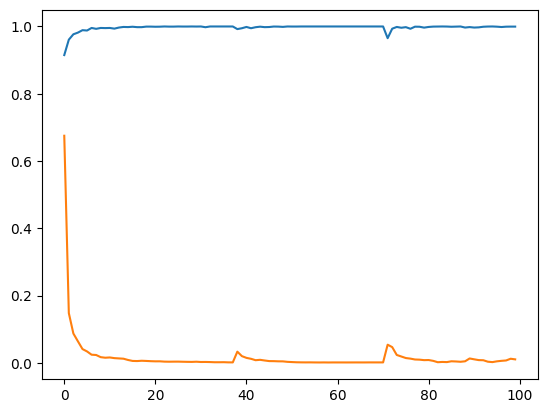

In [15]:
#Plot loss and accuracy of a model using loss array and val_loss array
import matplotlib.pyplot as plt

# validation_accuracies
#Plotting accuracy
plt.plot(validation_accuracies)
plt.plot(train_losses)
